<a href="https://colab.research.google.com/github/chinu1997/Capstone-4-Team-3-/blob/main/Chinmaya_Devprasad_of_Topic_Modeling_on_News_Articles_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import string
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
News=[]
Type=[]
path="/content/drive/MyDrive/Almabetter/Cohort Aravali/Module 4/Capstone-4/Topic Modeling on BBC News Articles/bbc"
folders=["business","entertainment","politics","sport","tech"] 
for i in folders:
    files=os.listdir(path+'/'+i)
    for text_file in files:
        file_path=path + '/'+i+'/'+text_file
        with open(file_path,'rb') as f:
            data=f.read()
        News.append(data)
        Type.append(i)

data={'news':News,'type':Type}
df = pd.DataFrame(data)

In [ ]:
df.head()

,news,type
0,b'US budget deficit to reach $368bn\n\nThe US ...,business
1,b'World leaders gather to face uncertainty\n\n...,business
2,b'Swiss cement firm in buying spree\n\nSwiss c...,business
3,"b""India's Reliance family feud heats up\n\nThe...",business
4,b'UK young top Euro earnings league\n\nBritish...,business


In [ ]:
df.shape

(2225, 2)

Text(0.5, 1.0, 'Type Of news Counts')

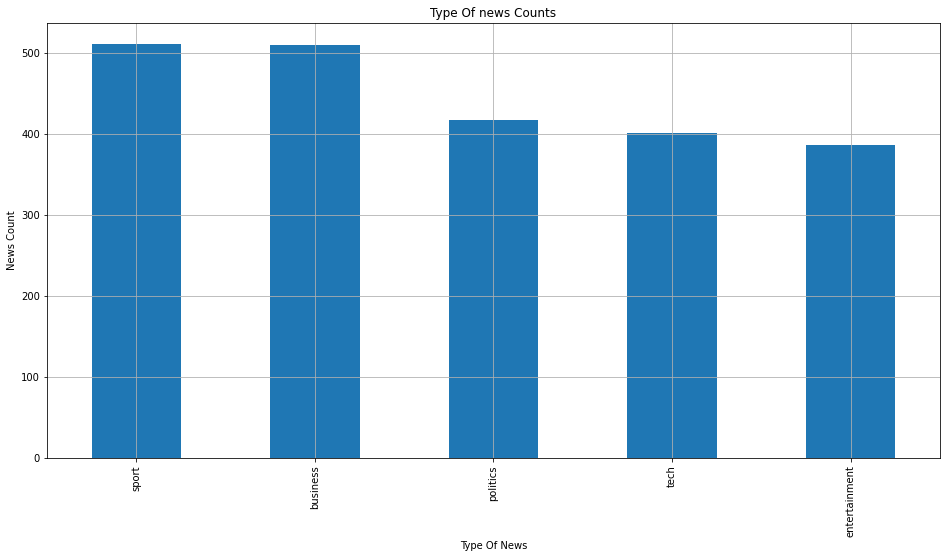

In [ ]:
plt.figure(figsize=(16,8))
df['type'].value_counts().plot(kind='bar',grid=True)
plt.xlabel("Type Of News")
plt.ylabel("News Count")
plt.title("Type Of news Counts")

In [ ]:
df.head()

,news,type
0,bUS budget deficit reach 368bnnnThe US budget ...,business
1,bWorld leaders gather face uncertaintynnMore 2...,business
2,bSwiss cement firm buying spreennSwiss cement ...,business
3,bIndias Reliance family feud heats upnnThe ong...,business
4,bUK young top Euro earnings leaguennBritish ch...,business


In [ ]:
df['news'][0]

'budget deficit reach budget deficit set hit worsethanexpecte year official say cost military operation still need factored analyst say deficit could end 100bn red cbo forecast say would shortfall fiscal year recent month dollar weaken market jitter size budget trade deficit gap export import widen 60bn record figure say envisage orderly decline greenback next year twin deficit drive dollar investor away nonpartisan fiscal watchdog note decline help exporter boost economic budget deficit hit record month reach 377bn previous fiscal year also forecast total shortfall year improvement previous projection however analyst say new figure fail take account potential cost president plan revamp state pension extend tax cut figure could also worsen military cost blame size deficit slow economic condition attack ongoing military operation election pledge halve budget deficit year democrat accuse president exclude iraqrelate cost previous budget meet aim reduce deficit charge administration deny 

In [ ]:
df['news'] = df['news'].astype('str') 

In [ ]:
def Change_text(msg):
  punc=[char for char in msg if str(char) not in string.punctuation]
  no_punc=''.join(punc)
  main_text=[word for word in no_punc.split() if word.lower() not in stopwords.words('english')]
  return ' '.join(main_text)

In [ ]:

def lemmatization(texts):
  sentence=''
  allowed_postags=['NOUN','ADJ','VERB','ADV']
  texts_out=[]
  doc=nlp(texts)
  texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return ' '.join(texts_out[0])

In [ ]:
df['news']=df['news'].apply(Change_text)

In [ ]:
nlp=spacy.load('en',disable=['parser', 'ner'])
df['news']=df['news'].apply(lemmatization)

In [ ]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

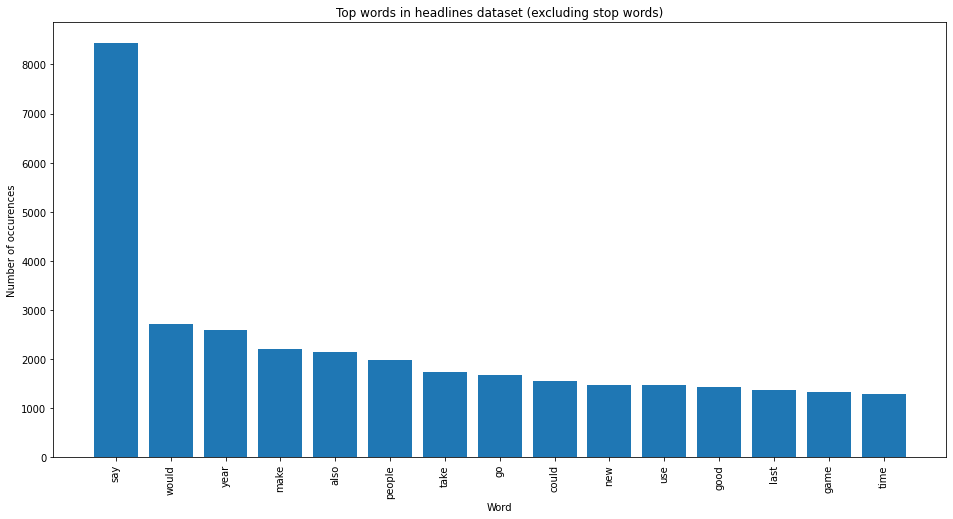

In [ ]:
count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['news'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

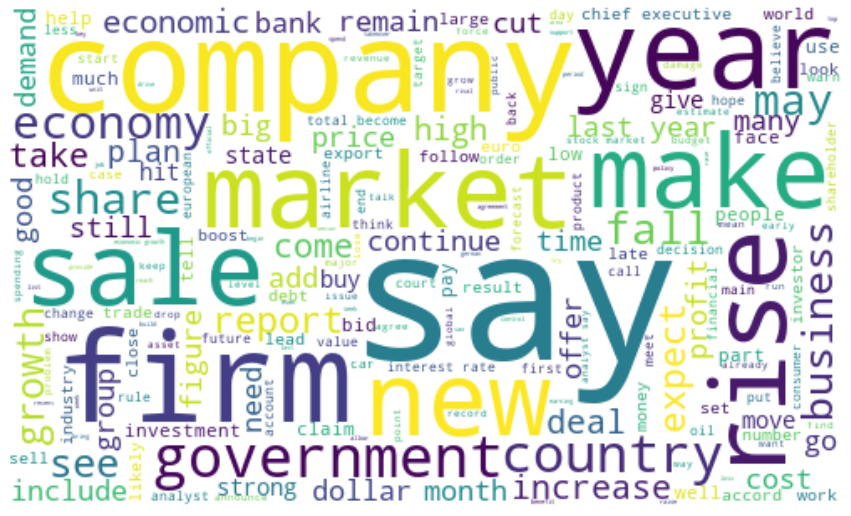

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='business']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

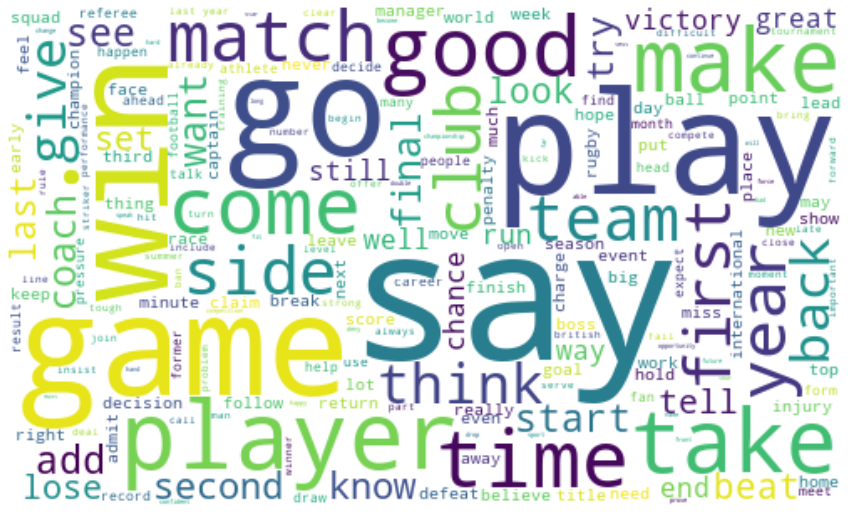

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='sport']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=5000,min_df=0.05)

In [ ]:
matrix=vectorizer.fit_transform(df['news'])

In [ ]:
df1 = pd.DataFrame(matrix.todense() , columns=vectorizer.get_feature_names())

In [ ]:
df1.head()

,able,accept,access,accord,account,accuse,act,action,add,admit,affect,age,ago,agree,ahead,aim,allow,almost,already,also,always,amount,analyst,announce,annual,appear,area,argue,ask,attack,attempt,available,average,avoid,award,away,back,bad,base,battle,...,think,third,time,title,today,together,top,total,tough,trade,trial,try,turn,tv,understand,use,user,value,version,victory,video,view,vote,want,warn,watch,way,website,week,well,whole,win,winner,work,world,would,write,year,yet,young
0,0.0,0.000000,0.0,0.0,0.11217,0.111560,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.104747,0.0,0.0,0.000000,0.094642,0.0,0.0,0.193268,0.000000,0.000000,0.0,0.0,0.0,0.094275,0.105232,0.0,0.0,0.000000,0.0,0.0,0.102135,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.108868,0.000000,0.112583,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.049375,0.0,0.281926,0.0,0.000000
1,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.056103,0.000000,0.000000,0.000000,0.0,0.0,0.045305,0.051000,0.0,0.0,0.000000,0.052475,0.062444,0.0,0.0,0.0,0.050802,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.039502,0.0,0.0,0.0,...,0.000000,0.000000,0.032497,0.0,0.0,0.062073,0.045702,0.000000,0.062696,0.060668,0.0,0.090437,0.0,0.0,0.000000,0.072301,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.062952,0.0,0.0,0.0,0.038815,0.0,0.0,0.0,0.0,0.118231,0.000000,0.0,0.101281,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.105675,0.103196,0.000000,0.0,0.0,0.000000,0.049031,0.0,0.0,0.000000,0.000000,0.120067,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.075086,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.116225,0.0,0.0,0.0,0.0,0.0,0.071277,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.151557,0.000000,0.0,0.000000,0.0,0.000000
3,0.0,0.113788,0.0,0.0,0.00000,0.215532,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.091422,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.091069,0.000000,0.0,0.0,0.000000,0.0,0.0,0.098661,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.112848,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.045389,0.0,0.104463
4,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.07779,0.0,0.0,0.136888,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.111823,0.000000,0.268186,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.138986,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.104662,0.069785,0.0,0.0,0.000000,0.196285,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.232890,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.125139
